<a href="https://colab.research.google.com/github/pbhuch/GL_DecA_G4_NLP1/blob/NLP1_PB/CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part -1

#### DOMAIN: Entertainment
#### CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

#### DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

Importing Libraries

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
from matplotlib import pyplot

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/computer vision/")

Loading the data

In [ ]:
data = np.load("/content/drive/MyDrive/computer vision/Part 1- Train data - images.npy",allow_pickle=True)

In [ ]:
data.shape

(409, 2)

Checking a Sample

(337, 600, 3)


<function matplotlib.pyplot.show>

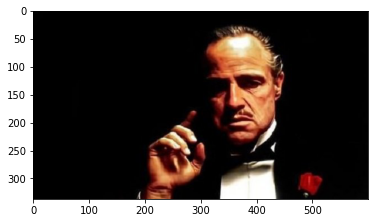

In [ ]:
sampleData = data[10,0]
print (sampleData.shape)
plt.imshow(sampleData)
plt.show

In [ ]:
data[100,1]

[{'imageHeight': 720,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.26327193932827736, 'y': 0.18497109826589594},
   {'x': 0.3206933911159263, 'y': 0.28516377649325625}]},
 {'imageHeight': 720,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4257854821235103, 'y': 0.23121387283236994},
   {'x': 0.49837486457204766, 'y': 0.34104046242774566}]},
 {'imageHeight': 720,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6197183098591549, 'y': 0.29865125240847784},
   {'x': 0.6988082340195017, 'y': 0.4624277456647399}]}]

2. Create features (images) and labels (mask) using that data.

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [ ]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
print('Shape of X_train: ', X_train.shape)
print('Shape of mask array: ', masks.shape)

Shape of X_train:  (409, 224, 224, 3)
Shape of mask array:  (409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


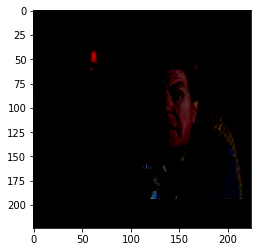

In [ ]:
n = 20
print(X_train[n])
pyplot.imshow(X_train[n])

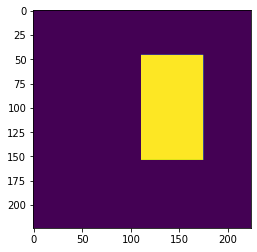

In [ ]:
pyplot.imshow(masks[n])

Mask detection model

In [ ]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

In [ ]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output 
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [ ]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17235968/17225924 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

Design your own Dice Coefficient and Loss function.

In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

Train, tune and test the model

In [ ]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

Define Checkpoint and early stopping

In [ ]:
PATIENCE = 5

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/computer vision/modelsaved.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="auto", save_freq=1)

In [ ]:
stop = EarlyStopping(monitor="loss", patience=PATIENCE, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=PATIENCE, min_lr=1e-6, verbose=1, mode="min")

Evaluate the model using testing data

In [ ]:
EPOCHS = 10
BATCH_SIZE = 1
THREADS = 5

In [ ]:
model.fit(x=X_train, y=masks, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[checkpoint,reduce_lr, stop], validation_split=0.2, workers=THREADS, use_multiprocessing=True)

Streaming output truncated to the last 5000 lines.
124/327 [==========>...................] - ETA: 3:11 - loss: 0.6459 - dice_coefficient: 0.6710
Epoch 00003: loss did not improve from 0.50850
125/327 [==========>...................] - ETA: 3:10 - loss: 0.6442 - dice_coefficient: 0.6716
Epoch 00003: loss did not improve from 0.50850
126/327 [==========>...................] - ETA: 3:09 - loss: 0.6436 - dice_coefficient: 0.6711
Epoch 00003: loss did not improve from 0.50850
127/327 [==========>...................] - ETA: 3:08 - loss: 0.6491 - dice_coefficient: 0.6708
Epoch 00003: loss did not improve from 0.50850
128/327 [==========>...................] - ETA: 3:07 - loss: 0.6464 - dice_coefficient: 0.6719
Epoch 00003: loss did not improve from 0.50850
129/327 [==========>...................] - ETA: 3:06 - loss: 0.6446 - dice_coefficient: 0.6730
Epoch 00003: loss did not improve from 0.50850
130/327 [==========>...................] - ETA: 3:05 - loss: 0.6445 - dice_coefficient: 0.6729
Ep

In [ ]:
model.load_weights("/content/drive/MyDrive/computer vision/modelsaved.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


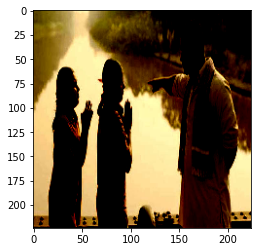

In [ ]:
n = 29
sample_image = X_train[n]
final_image = sample_image
pyplot.imshow(sample_image)

In [ ]:
sample_image.shape

(224, 224, 3)

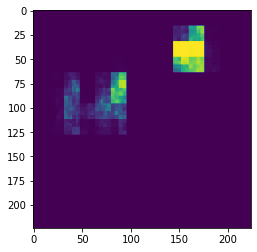

In [ ]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x=sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
pyplot.imshow(pred_mask)

Impose the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


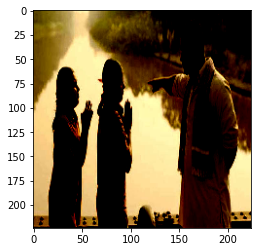

In [ ]:
final_pred_mask = np.resize(pred_mask, (224,224))
final_image = np.resize(sample_image,  (224,224,3))
pyplot.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


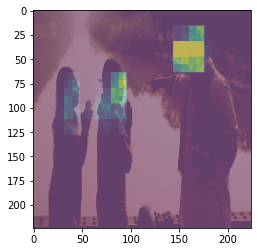

In [ ]:
fig = plt.figure()
im1 = plt.imshow(final_image, alpha=0.5)
im2 = plt.imshow(final_pred_mask, alpha=0.5)
plt.show()

Use the “Prediction image” as an input to your designed model and display the output of the image

(500, 500, 3)


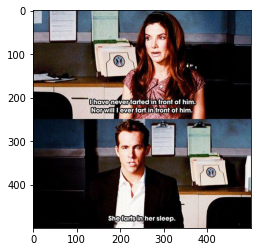

In [ ]:
img = plt.imread('/content/drive/MyDrive/computer vision/Part 1Test Data - Prediction Image.jpeg')
plt.imshow(img)
print(img.shape)

In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = tf.stack((cx, cy, w, h), axis=-1)
    return boxes


def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
# Here `bbox` is the abbreviation for bounding box
face1_bbox, face2_bbox = [230.0, 20.0, 340.0, 130.0], [180.0, 250.0, 280.0, 390.0]

In [ ]:
boxes = tf.constant((face1_bbox, face2_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes


<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                             height=bbox[3] - bbox[1], fill=False,
                             edgecolor=color, linewidth=2)

(500, 500, 3)


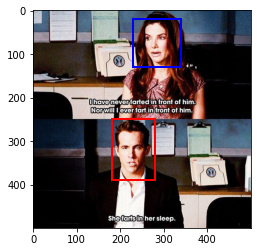

In [ ]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(face1_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(face2_bbox, 'red'))
print(img.shape)

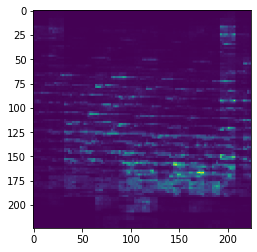

In [ ]:
img = np.resize(img, (1,224,224, 3))
pred_mask1 = model.predict(x = img)
pred_mask1 = np.resize(pred_mask1, (224,224))
plt.imshow(pred_mask1)

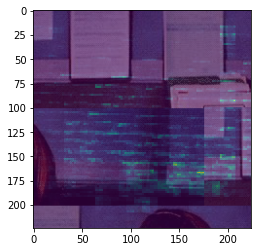

In [ ]:
final_pred_mask = np.resize(pred_mask1, (224,224))
final_image = np.resize(img, (500,500,3))
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha = 0.6)
plt.show()

Conclusion

Part 1 of the project was about how we can make use of the UNET layers to train, fit and evaluate model with an objective to predict the boundaries(mask) around the face in a given image.

1. Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics. Model checkpoint, early stopping and learning rate reducers were used as callbacks.
2. Data was split into train and validation using 90/10 ratio. Best loss I got is 0.4323 and dice_coefficient of 0.7652 on the training data with just 10 epochs.
3. Model weights for this were used and then used to predict on validation data to get mask.
4. Further checked on sample image and imposed mask on the image. As seen in the above images, it can be seen that model does a very good job in predicting the masks.

## Part 2 :
#### DOMAIN: Face recognition
#### CONTEXT: Company X intends to build a face identification model to recognise human faces.
#### DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
#### PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.


#### Importing libraries

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.1.5
Numpy version: 1.19.5
Scikit-learn version: 1.0.1
Tensorflow version: 2.7.0
CV version: 4.1.2


Change current working directory to project folder

In [4]:
import os; 
os.chdir('/content/drive/MyDrive/computer vision/Part 2')

In [6]:
train_images = 'Part 3 - Aligned Face Dataset from Pinterest.zip'

In [7]:
import zipfile
archive = zipfile.ZipFile(train_images, 'r')
archive.extractall()

Defining a function to load the images from the extracted folder and mapping each image with person id

In [8]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

Defining a function to load image from the metadata

In [9]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

Load one image using the function "load_image"

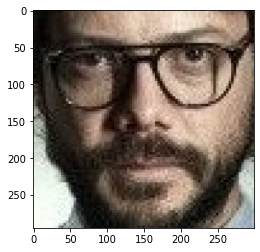

In [11]:
img_100 = load_image(metadata[100].image_path())
plt.imshow(img_100)

Using predefined model for VGG face

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

Loading the model defined above
Then loading the given weight file named "vgg_face_weights.h5"

In [13]:
model = vgg_face()
model.load_weights('Part 3 - vgg_face_weights.h5')

Get vgg_face_descriptor

In [14]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [15]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [16]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i in range(len(metadata)):
    img_path = metadata[i].image_path()
    print(i, metadata[i])
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224, 224))
    
    #obtaining embedding vectors of all images
    embedding_vectors = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
    embeddings[i] = embedding_vectors    

Streaming output truncated to the last 5000 lines.
5770 PINS/pins_Sophie Turner/Sophie Turner57_1691.jpg
5771 PINS/pins_Sophie Turner/Sophie Turner58_1668.jpg
5772 PINS/pins_Sophie Turner/Sophie Turner59_1653.jpg
5773 PINS/pins_Sophie Turner/Sophie Turner5_1638.jpg
5774 PINS/pins_Sophie Turner/Sophie Turner60_1650.jpg
5775 PINS/pins_Sophie Turner/Sophie Turner61_1725.jpg
5776 PINS/pins_Sophie Turner/Sophie Turner62_1698.jpg
5777 PINS/pins_Sophie Turner/Sophie Turner64_1722.jpg
5778 PINS/pins_Sophie Turner/Sophie Turner65_1682.jpg
5779 PINS/pins_Sophie Turner/Sophie Turner66_1688.jpg
5780 PINS/pins_Sophie Turner/Sophie Turner68_1651.jpg
5781 PINS/pins_Sophie Turner/Sophie Turner69_1662.jpg
5782 PINS/pins_Sophie Turner/Sophie Turner70_1642.jpg
5783 PINS/pins_Sophie Turner/Sophie Turner71_1751.jpg
5784 PINS/pins_Sophie Turner/Sophie Turner72_1726.jpg
5785 PINS/pins_Sophie Turner/Sophie Turner73_1738.jpg
5786 PINS/pins_Sophie Turner/Sophie Turner74_1694.jpg
5787 PINS/pins_Sophie Turner/Sop

Considering distance metric as "Squared L2 distance"
Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [17]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plotting images and gettin distance between the pairs given below
#### 2, 3 and 2, 180
#### 30, 31 and 30, 100
#### 70, 72 and 70, 115

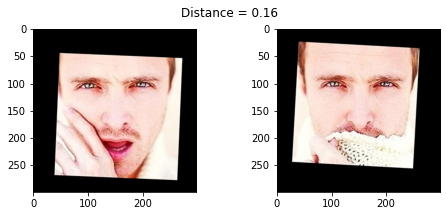

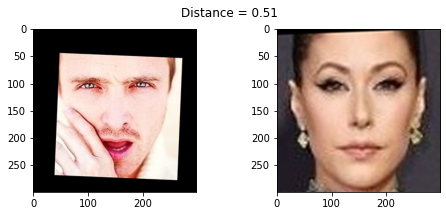

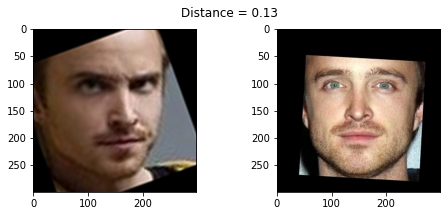

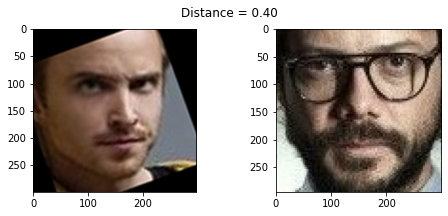

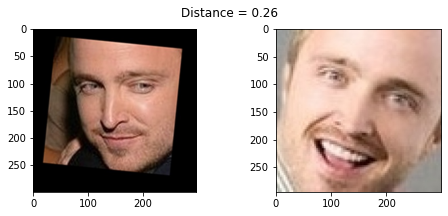

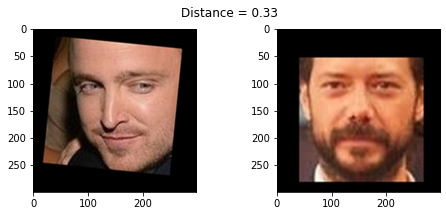

In [18]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

show_pair(30, 31)
show_pair(30,100)

show_pair(70, 72)
show_pair(70,115)

Creating train and test sets

In [19]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

#### Encoding the targets
#### Using LabelEncoder

In [20]:
from sklearn.preprocessing import LabelEncoder

target = np.array([m.name for m in metadata])
enc = LabelEncoder()
enc.fit(target)

y = enc.transform(target)
y_train = y[train_idx]
y_test = y[test_idx]

In [21]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

Scaling the features using StandardScaler

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [23]:
display(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

#### Reducing feature dimensions using Principal Component Analysis
#### Setting the parameter n_components=128

In [24]:
from sklearn.decomposition import PCA

pca = PCA() 
  
X_train = pca.fit_transform(X_train_scaled) 
X_test = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[1.35889070e-01 5.39799555e-02 3.99037969e-02 ... 1.67688364e-09
 1.65443039e-09 9.19486950e-11]


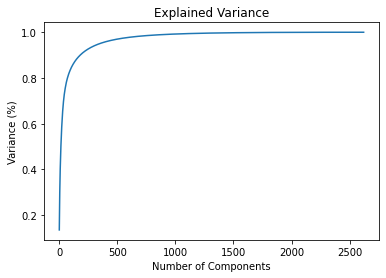

In [25]:
plt.figure()
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

In [26]:
pca = PCA(n_components = 128) 
  
X_train = pca.fit_transform(X_train) 
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[0.13588907 0.05397996 0.0399038  0.03685076 0.0340078  0.03130052
 0.0259161  0.02335011 0.0210263  0.01942921 0.01818738 0.01701085
 0.01657934 0.01562091 0.01414857 0.01363428 0.01303946 0.01227737
 0.01155234 0.01134523 0.01092548 0.01055393 0.00961389 0.00936725
 0.00914728 0.00883087 0.00833982 0.0076841  0.0076045  0.00736519
 0.00699927 0.00664536 0.00633479 0.00620419 0.00572142 0.00535153
 0.00529045 0.0051194  0.00505976 0.00482456 0.00438459 0.00434225
 0.0039447  0.00393708 0.00370292 0.00356456 0.00340717 0.00334461
 0.00328386 0.00319783 0.00313175 0.00307634 0.00290435 0.00282541
 0.00279101 0.00273295 0.00268621 0.00261383 0.00253895 0.00248398
 0.00237262 0.00231873 0.00225091 0.00217072 0.00210901 0.00205765
 0.00200232 0.00194651 0.00187787 0.00184866 0.00182581 0.00179021
 0.00174437 0.00173486 0.00169883 0.00165647 0.00163982 0.00161589
 0.00157054 0.00155135 0.00152514 0.00149543 0.00146945 0.00143463
 0.00140346 0.00137586 0.00136122 0.00134122 0.0013151  0.0012

#### Using SVM Classifier to predict the person in the given image
#### Fitting the classifier and printing the score

In [27]:
from sklearn.svm import SVC

svc = SVC(C = 1.0, kernel = 'rbf', gamma = 'scale')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score

print('Accuracy Score of SVC Model- ', accuracy_score(y_test, svc_pred))

Accuracy Score of SVC Model-  0.9590643274853801


Taking 10th image from test set and plot the image and
Reporting to which person(folder name in dataset) the image belongs to

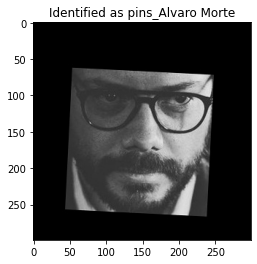

In [29]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([X_test[example_idx]]) #### Add your code here ####
example_identity = enc.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

Few more sample to check and validate

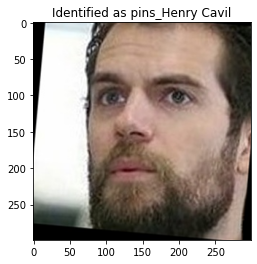

In [30]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 300

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([X_test[example_idx]]) #### Add your code here ####
example_identity = enc.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

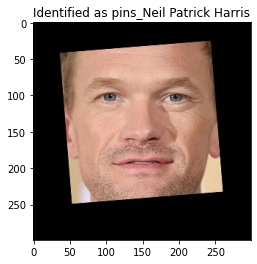

In [31]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 500

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([X_test[example_idx]]) #### Add your code here ####
example_identity = enc.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');